In [88]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.status()

  Activating project at `~/Documents/Carnegie-Mellon/Chatterjee Group/Programming/heisenberg-model/Biquadratic.jl/analysis`


Status `~/Documents/Carnegie-Mellon/Chatterjee Group/Programming/heisenberg-model/Biquadratic.jl/analysis/Project.toml`
  [13f3f980] CairoMakie v0.15.3
  [780c37f4] Carlo v0.2.4
  [a93c6f00] DataFrames v1.7.0
  [f67ccb44] HDF5 v0.17.2


In [89]:
using CairoMakie
using Carlo.ResultTools
using DataFrames
using HDF5
using LinearAlgebra

In [90]:
# Parse DataFrame from ResultTools into more readily useable form
cleandata(filepath::AbstractString) = select(
    DataFrame(ResultTools.dataframe(filepath)),
    [:T, :K, :Lx, :Ly, :Mag, :Energy, :Dxπ, :Dyπ, :P],
)

cleandata (generic function with 1 method)

In [91]:
function generatePlot(data::AbstractDataFrame, x, y; fig=Figure(), fig_pos=(1,1),
                      title, xlabel, ylabel, line=false, label="")
    fig[fig_pos...] = Axis(fig; title, xlabel, ylabel)

    vals = getfield.(data[:, y], :val)
    errs = getfield.(data[:, y], :err)
    scatter!(data[:, x], vals; label)
    if line
        lines!(data[:, x], vals)
    end
    errorbars!(data[:, x], vals, errs)

    return fig
end

function generatePlot(data::GroupedDataFrame, x, y; fig=Figure(), fig_pos=(1,1),
                      title, xlabel, ylabel, line=false)
    fig = Figure()
    fig[fig_pos...] = Axis(fig; title, xlabel, ylabel)

    for key in keys(data)
        group = data[key]
        vals = getfield.(group[:, y], :val)
        errs = getfield.(group[:, y], :err)
        scatter!(group[:, x], vals, label="$(NamedTuple(key))")
        if line
            lines!(group[:, x], vals)
        end
        errorbars!(group[:, x], vals, errs)
    end

    axislegend()

    return fig
end

generatePlot (generic function with 2 methods)

In [92]:
jobname = "temp-sweep"
data = groupby(cleandata("../jobs/" * jobname * ".results.json"), [:K])

Row,T,K,Lx,Ly,Mag,Energy,Dxπ,Dyπ,P
,Float64,Float64,Int64,Int64,Measurem…,Measurem…,Measurem…,Measurem…,Measurem…
1,0.01,-0.005,40,40,0.001487±6.4e-5,-1.97743±8.8e-5,-0.4323±0.0033,-0.4323±0.0033,0.0316±0.0028
2,0.05,-0.005,40,40,0.0035±0.0001,-1.94346±0.00019,0.153±0.012,0.153±0.012,0.6211±0.0038
3,0.1,-0.005,40,40,0.00503±0.00012,-1.8914±0.00019,-0.6765±0.0098,-0.6763±0.0099,0.208±0.011
4,0.15,-0.005,40,40,0.00619±0.00012,-1.8395±0.00031,-0.508±0.013,-0.508±0.013,0.247±0.011
5,0.2,-0.005,40,40,0.00708±0.00014,-1.79936±0.00037,-0.7579±0.0057,-0.7576±0.0057,0.135±0.013
6,0.25,-0.005,40,40,0.008±0.00012,-1.74502±0.00045,0.695±0.0077,0.6949±0.0077,0.0816±0.0083
7,0.3,-0.005,40,40,0.00867±0.00014,-1.69017±0.00072,0.59±0.024,0.59±0.024,0.187±0.03
8,0.35,-0.005,40,40,0.00961±0.00012,-1.631±0.0007,0.286±0.052,0.286±0.052,0.375±0.036
9,0.4,-0.005,40,40,0.01019±0.00013,-1.57562±0.00098,-0.476±0.015,-0.476±0.015,0.159±0.02


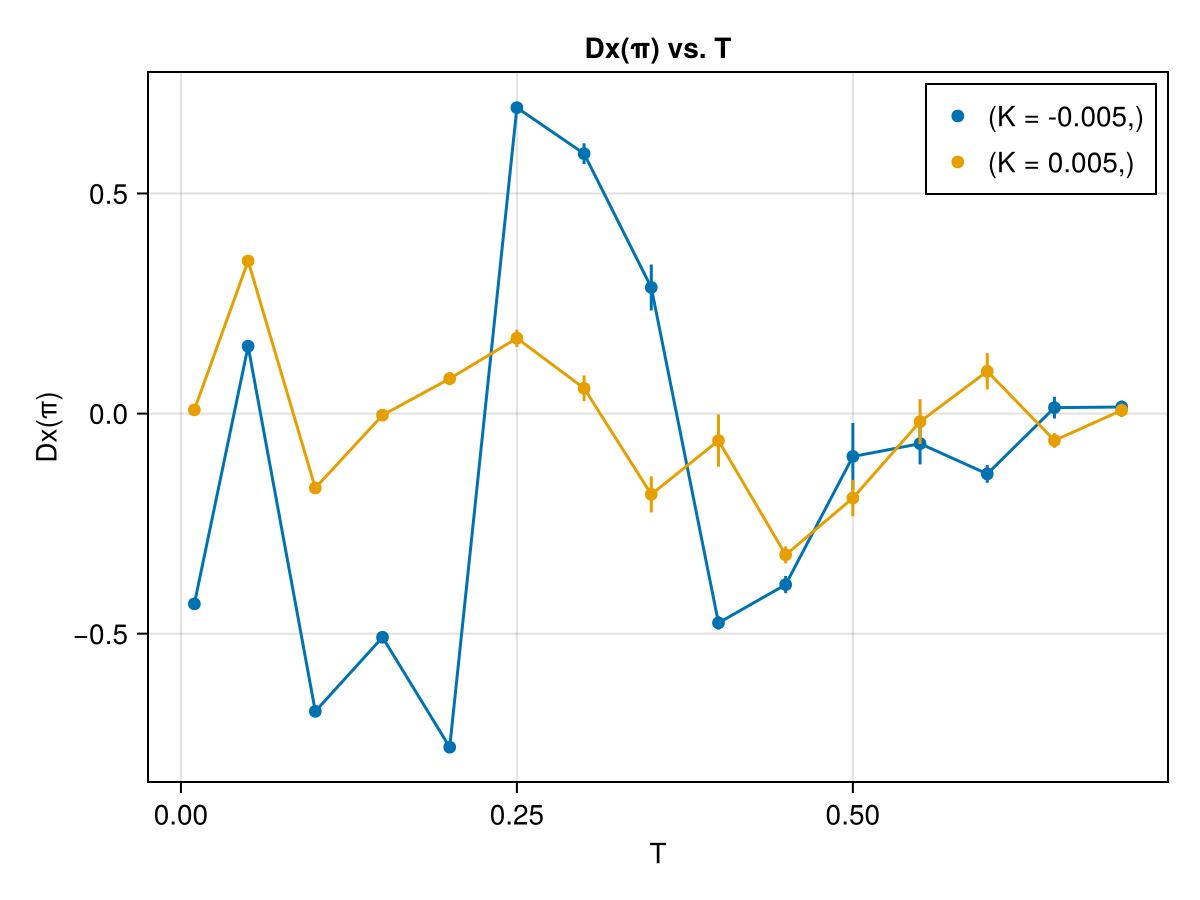

In [93]:
fig = generatePlot(
    data, :T, :Dxπ;
    title="Dx(π) vs. T",
    xlabel="T",
    ylabel="Dx(π)",
    line=true
)

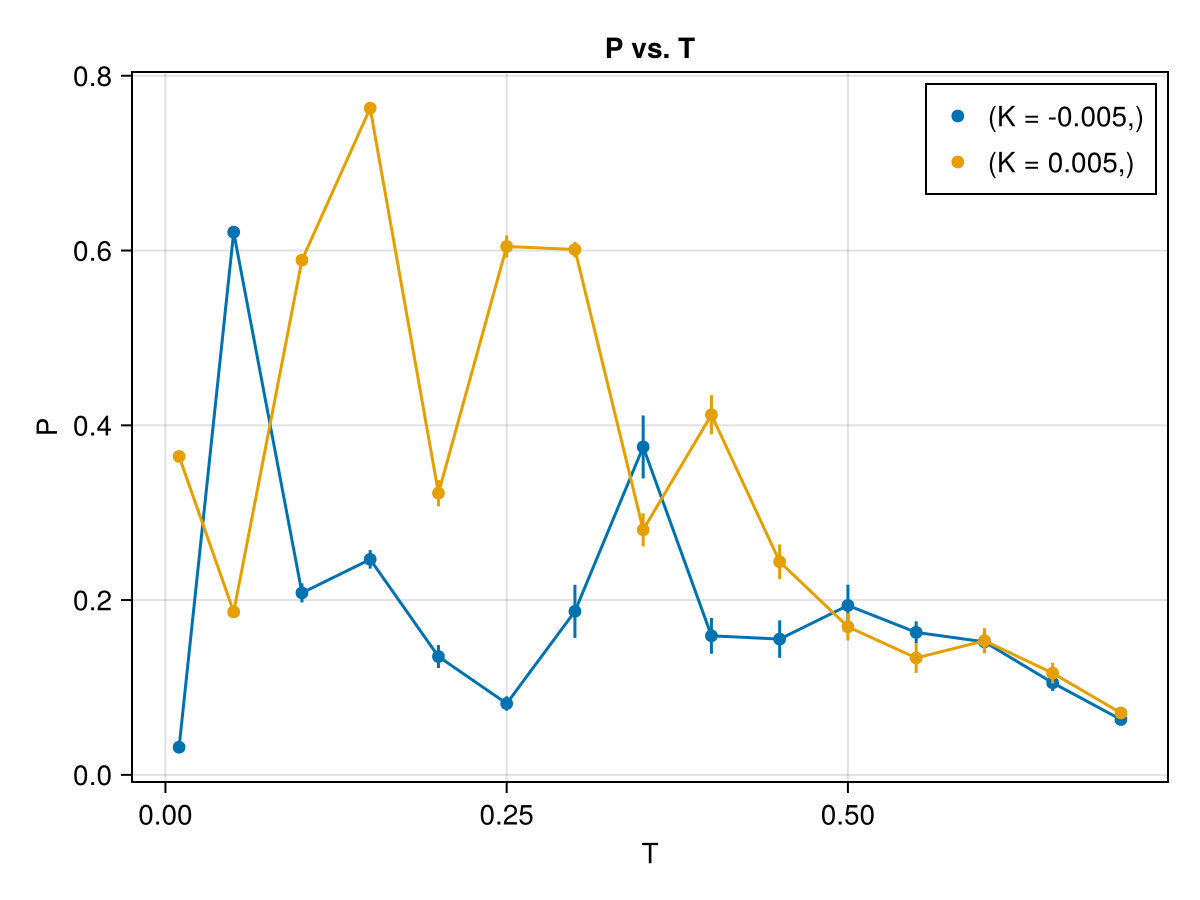

In [94]:
fig = generatePlot(
    data, :T, :P;
    title="P vs. T",
    xlabel="T",
    ylabel="P",
    line=true
)

In [95]:
function generate_mctime_plot(task_no::Int)
    fig = Figure(size=(800, 400))

    ax_energy = fig[1,1] = Axis(
        fig,
        title="Energy vs. Bin #",
        xlabel="Bin #",
        ylabel="Energy",
        xminorticksvisible=true
    )
    ax_Dxπ = fig[1,2] = Axis(
        fig,
        title="Dx(π) vs. Bin #",
        xlabel="Bin #",
        ylabel="Dx(π)",
        xminorticksvisible=true
    )

    task_str = lpad(task_no, 4, "0")
    h5open("../jobs/$jobname.data/task$task_str/run0001.meas.h5") do file
        observables = file["observables"]
        energy_samples = read(observables, "Energy/samples")
        n = length(energy_samples)
        init = 1
        lines!(
            ax_energy,
            collect(init:n),
            energy_samples[init:n],
        )
        Dxπ_samples = read(observables, "Dxπ/samples")
        lines!(
            ax_Dxπ,
            collect(init:n),
            Dxπ_samples[init:n],
        )
    end

    return fig
end

generate_mctime_plot (generic function with 1 method)

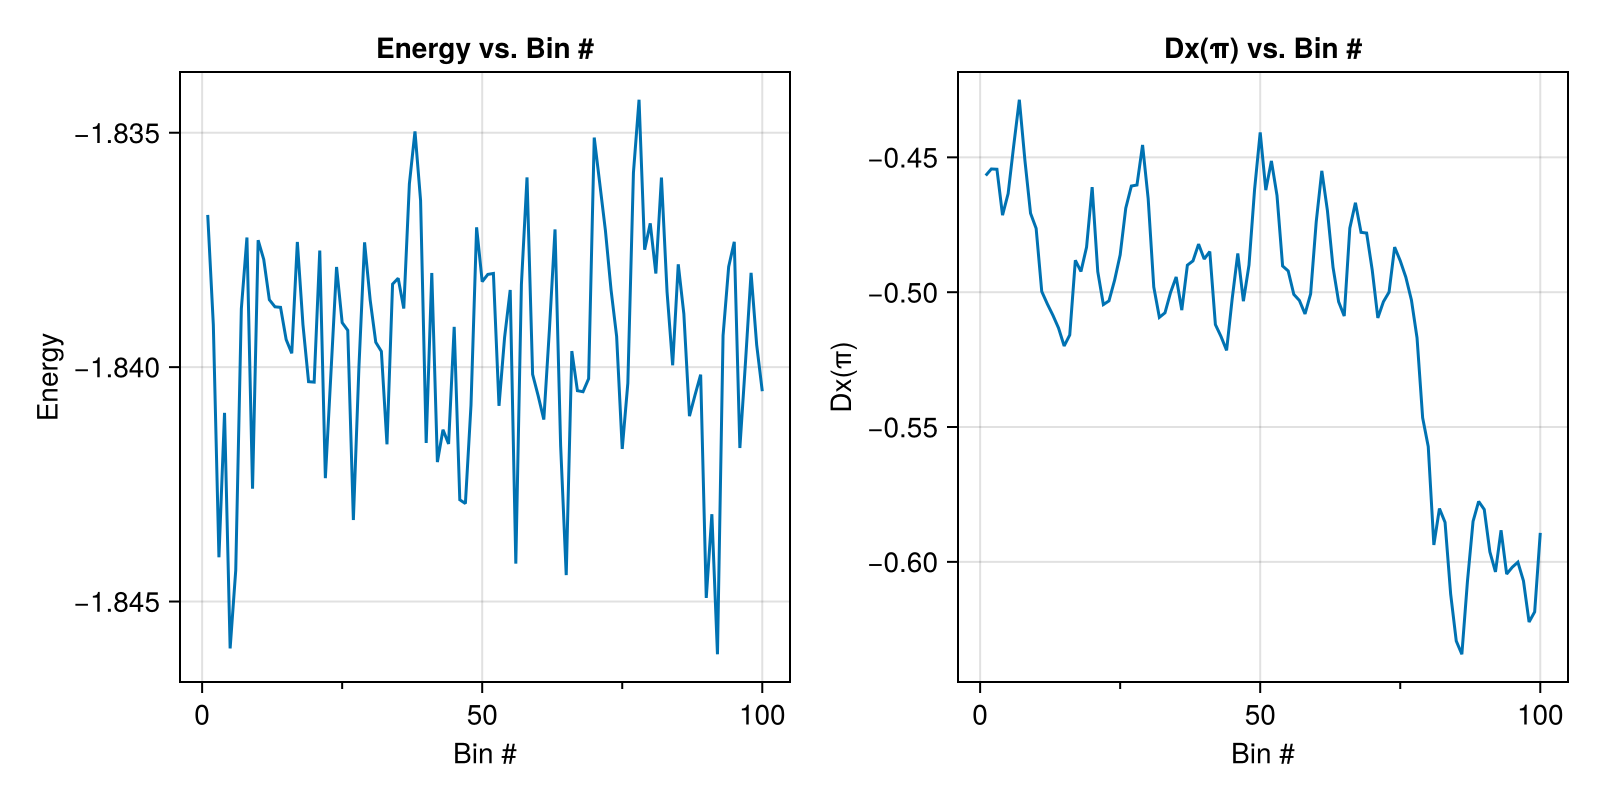

In [100]:
generate_mctime_plot(4)

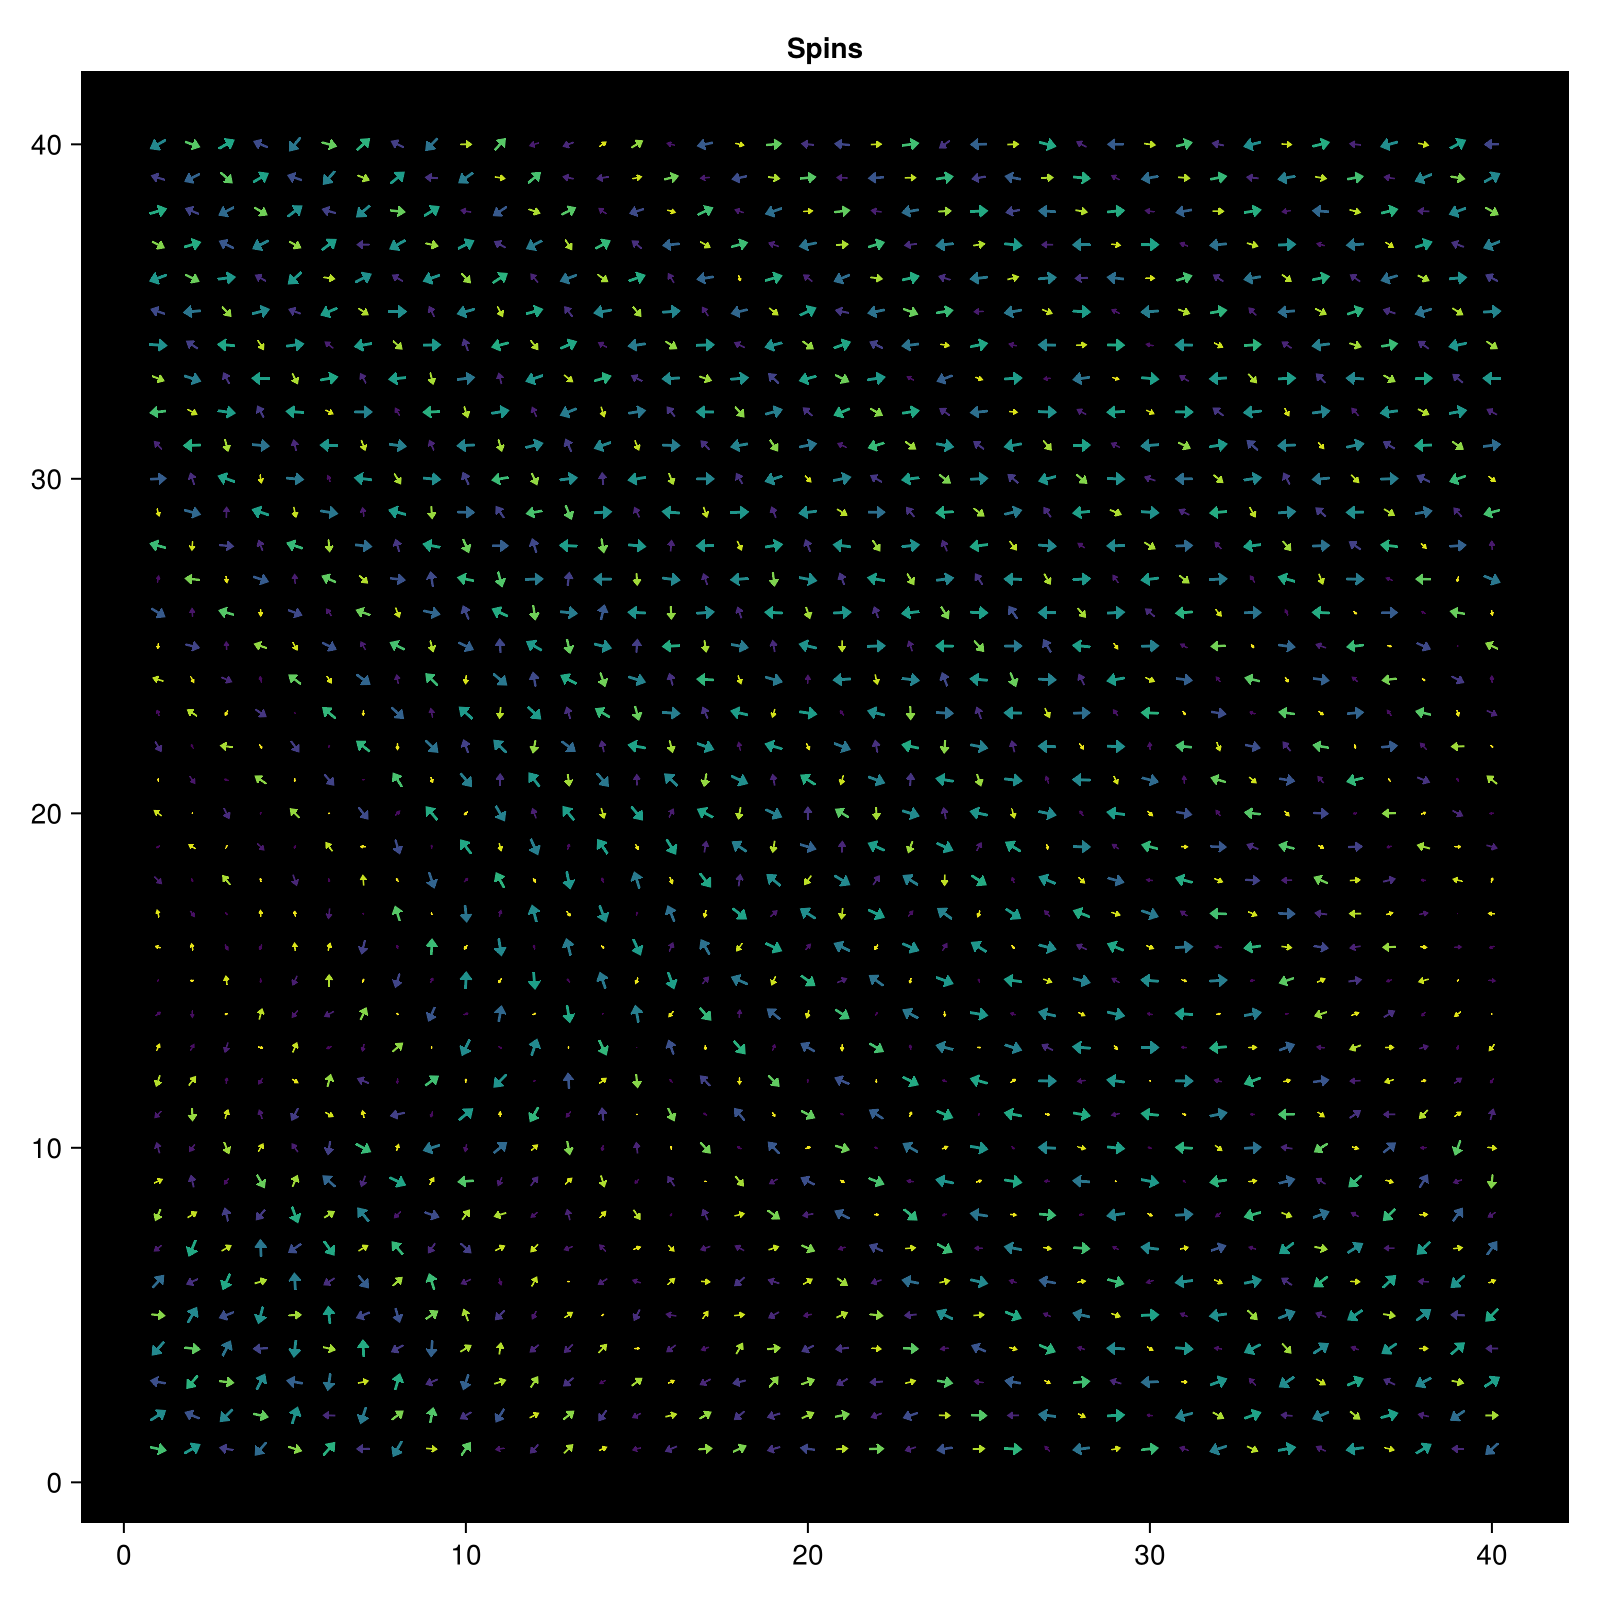

In [97]:
task_no = "02"
file = h5open("../jobs/$jobname.data/task00" * task_no * "/run0001.dump.h5")
spins = map(
    t -> [t[:data][1], t[:data][2], t[:data][3]],
    read(file, "simulation/spins")
)
spin_xs = map(v -> v[1], spins)
spin_ys = map(v -> v[2], spins)
spin_zs = map(v -> v[3], spins)
Lx, Ly = size(spins)
close(file)

fig = Figure(size=(800, 800))
fig[1,1] = Axis(fig; title="Spins", backgroundcolor="black")

strength = vec(spin_zs)
arrows2d!(1:Lx, 1:Ly, spin_xs, spin_ys, lengthscale=0.5, align=:center, color=strength)
fig